In [14]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio

def meow():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

In [2]:
# # # # MTS COVARIATES # # # #

p = os.path.join(DATA_DIR,'raw', 'Covid19_01262020_09262020.csv')
df = pd.read_csv(p)
# df

cols = [x for x in df.columns if x not in ['index','Date','confirmed_cases','deaths','foot_traffic']]
df = df[cols]

df['Fips'] = df.GISJOIN.apply(lambda x: x[1:3] + x[4:-1])
df['Fips'] = df.Fips.apply(lambda x: int(x))
df.drop_duplicates(inplace=True)
df.drop('GISJOIN',axis=1,inplace=True)
df.set_index('Fips',inplace=True,drop=True)


# # # # DEATH DATA # # # #

timestamp = '20241009-144131'

fpath = os.path.join(DATA_DIR,'processed', f'processed_naive_deaths_{timestamp}.csv')
df_deaths = pd.read_csv(fpath)
## Drop rows with nans.
df_deaths.dropna(inplace=True)
## Drop samples with negative inc deaths.
df_deaths = df_deaths[df_deaths.True_inc_deaths >= 0]

df = df_deaths.join(df,on='Fips')
# df = df[df.Date < 20210626]
df = df[df.Date < 20210000]
display(df)

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,...,OCCU1,OCCU2,OCCU3,OCCU4,OCCU5,DT,HD,HT,WI,OB
1,1001,1,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
2,1001,1,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
3,1001,1,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
4,1001,1,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
5,1001,1,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309883,56045,56,6891.0,576641,0.011950,20201128,37.000000,1.0,0.0,1.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309884,56045,56,6891.0,576641,0.011950,20201205,40.000000,2.0,1.0,1.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309885,56045,56,6891.0,576641,0.011950,20201212,43.000000,2.0,2.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309886,56045,56,6891.0,576641,0.011950,20201219,47.000000,2.0,2.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9


### <font color=blue> Prep data. Choose deaths transformation.

In [3]:
from epsampling.modeling import get_full_modeling_dfs

# df, df_acs = get_full_modeling_dfs(timestamp='20241009-144131')

# df = df[df.True_inc_deaths > 0]

df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1) / x.Pop * 100000, axis=1)
df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1) / x.Pop * 100000, axis=1)
df['State_deaths'] = df.apply(lambda x: (x.Proj_inc_deaths+1) / x.State_pop * 100000, axis=1)
df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1) / x.Pop * 100000, axis=1)

### <font color=magenta> Remove outliers.

In [4]:
from scipy import stats

df = df[np.abs(stats.zscore(df.Target)) < 5]
display(df)

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,...,OCCU5,DT,HD,HT,WI,OB,Target,Naive,State_deaths,Cumtm1
1,1001,1,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,...,15.02,9.9,200.6,93.2,8.7,33.2,6.868250,3.383881,1.686827,12.019437
2,1001,1,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,...,15.02,9.9,200.6,93.2,8.7,33.2,6.868250,3.081284,1.384231,17.170624
3,1001,1,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,...,15.02,9.9,200.6,93.2,8.7,33.2,3.434125,3.242551,1.545498,22.321812
4,1001,1,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,...,15.02,9.9,200.6,93.2,8.7,33.2,5.151187,3.485135,1.788082,24.038874
5,1001,1,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,...,15.02,9.9,200.6,93.2,8.7,33.2,12.019437,4.003713,2.306660,27.472999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309883,56045,56,6891.0,576641,0.011950,20201128,37.000000,1.0,0.0,1.0,...,16.69,8.6,144.8,76.2,6.0,41.9,29.023364,20.928152,6.589889,14.511682
309884,56045,56,6891.0,576641,0.011950,20201205,40.000000,2.0,1.0,1.0,...,16.69,8.6,144.8,76.2,6.0,41.9,29.023364,21.448407,7.110143,29.023364
309885,56045,56,6891.0,576641,0.011950,20201212,43.000000,2.0,2.0,0.0,...,16.69,8.6,144.8,76.2,6.0,41.9,14.511682,21.968661,7.630397,43.535046
309886,56045,56,6891.0,576641,0.011950,20201219,47.000000,2.0,2.0,0.0,...,16.69,8.6,144.8,76.2,6.0,41.9,14.511682,22.662334,8.324070,43.535046


### <font color=magenta> Add dummy variable for state.

In [5]:
dummies = pd.get_dummies(df['State_fips']).rename(columns=lambda x: 'State_' + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(['State_fips'], inplace=True, axis=1)
df

,Fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,Naive_inc_deaths,...,State_46,State_47,State_48,State_49,State_50,State_51,State_53,State_54,State_55,State_56
1,1001,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,0.970738,...,False,False,False,False,False,False,False,False,False,False
2,1001,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,0.794509,...,False,False,False,False,False,False,False,False,False,False
3,1001,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,0.888429,...,False,False,False,False,False,False,False,False,False,False
4,1001,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,1.029708,...,False,False,False,False,False,False,False,False,False,False
5,1001,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,1.331723,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309883,56045,6891.0,576641,0.011950,20201128,37.000000,1.0,0.0,1.0,0.442159,...,False,False,False,False,False,False,False,False,False,True
309884,56045,6891.0,576641,0.011950,20201205,40.000000,2.0,1.0,1.0,0.478010,...,False,False,False,False,False,False,False,False,False,True
309885,56045,6891.0,576641,0.011950,20201212,43.000000,2.0,2.0,0.0,0.513860,...,False,False,False,False,False,False,False,False,False,True
309886,56045,6891.0,576641,0.011950,20201219,47.000000,2.0,2.0,0.0,0.561661,...,False,False,False,False,False,False,False,False,False,True


In [6]:
not_feats = ['Target','Fips', 'State_fips', 'Date',
       'Proj_inc_deaths', 'True_cum_deaths', 'Cum_deaths_tm1',
       'True_inc_deaths', 'Naive_inc_deaths','Target']

feats = [x for x in df.columns if x not in not_feats]

print(feats)

['Pop', 'State_pop', 'Ratio', 'TPOP', 'POPDEN', 'Metro', 'Micro', 'POP1', 'POP2', 'POP3', 'POP4', 'Race1', 'Race2', 'Race3', 'Race4', 'FHH', 'HHS1', 'HHS2', 'HHS3', 'SE1', 'EDU1', 'EDU2', 'EDU3', 'EDU4', 'EDU5', 'PL', 'HHI1', 'HHI2', 'HHI3', 'HHI4', 'HHI5', 'MHHI', 'MNR', 'MGR', 'MHV', 'HI', 'MHI', 'QTPOP_percentage', 'OCCU1', 'OCCU2', 'OCCU3', 'OCCU4', 'OCCU5', 'DT', 'HD', 'HT', 'WI', 'OB', 'Naive', 'State_deaths', 'Cumtm1', 'State_1', 'State_4', 'State_5', 'State_6', 'State_8', 'State_9', 'State_10', 'State_12', 'State_13', 'State_15', 'State_16', 'State_17', 'State_18', 'State_19', 'State_20', 'State_21', 'State_22', 'State_23', 'State_24', 'State_25', 'State_26', 'State_27', 'State_28', 'State_29', 'State_30', 'State_31', 'State_32', 'State_33', 'State_34', 'State_35', 'State_36', 'State_37', 'State_38', 'State_39', 'State_40', 'State_41', 'State_42', 'State_44', 'State_45', 'State_46', 'State_47', 'State_48', 'State_49', 'State_50', 'State_51', 'State_53', 'State_54', 'State_55', 

### <font color=blue> Run models.

In [7]:
def line_plot(df, x_col, y_col, title=None):

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.regplot(data=df, x=x_col, y=y_col, 
                scatter_kws={'s':10, 'alpha':0.5}, 
                line_kws={'color':'k','linewidth':0.5},logx=False)
    
    if title is not None:
        plt.title(title) 

    plt.show()





============ TEST MONTH 14 ============

 > Deaths_Random Forest
  • MAE: 	2.64438
  • MedAE: 	1.23542
  • MSE: 	31.24667
  • RMSE: 	5.58987
  • r-squared: 	0.85516
  • relMAE: 	5948402135762.61
  • relMedAE: 	0.9444
 > Deaths_naive
  • MAE: 	2.43144
  • MedAE: 	1.4949
  • MSE: 	24.07105
  • RMSE: 	4.90623
  • r-squared: 	0.88842
  • relMAE: 	0.99739
  • relMedAE: 	1.0


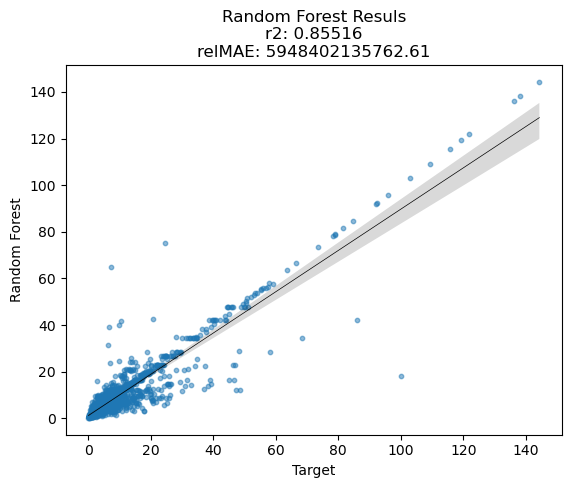

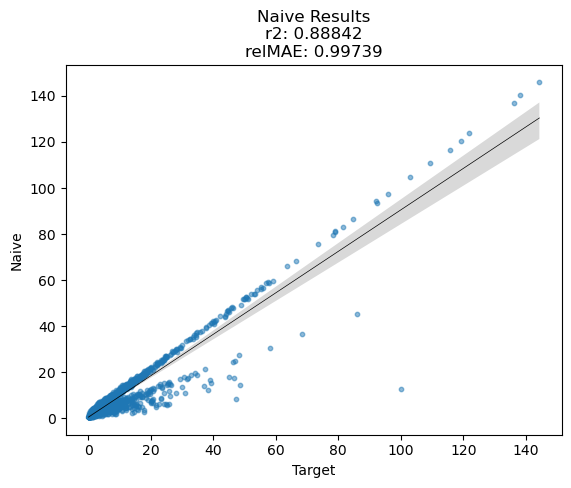

In [18]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

random.seed(666)

# # # # # # # # # # # # # # # # # # # #
num_runs = 1
alg = 'Random Forest'
data_frac = 0.5
# # # # # # # # # # # # # # # # # # # #

chunks = get_chunks(list(df.Date.unique()), num_runs)

## Pre-selected test-train splits to product a good mae and a bad mae
idc = random.sample(range(len(chunks)), num_runs)
# idc = [14,12]

for idx in idc:
    
    ########## RUN MODEL ########## 
    
    df_train, df_test = get_date_chunked_splits(df, chunks, 
                                                idx, samp_frac=data_frac)
    
#     feats = list(df_acs.columns) + ['State','Cumtm1','Naive',
#                                     'State_pop','Ratio','Pop']
        
    X_train = df_train[feats]
    X_test = df_test[feats]

    y_train = df_train['Target']
    y_test = df_test['Target']
    y_naive = df_test['Naive']
    
    if alg=='Linear':
        reg = LinearRegression().fit(X_train, y_train)
    elif alg=='Lasso':
        reg = Lasso(alpha=0.1).fit(X_train, y_train)
    elif alg=='Random Forest':
        reg = RandomForestRegressor(random_state=666,
                                    max_depth=14,
                                    bootstrap=False,
                                   ).fit(X_train, y_train)

    df_test[alg] = reg.predict(X_test)
    
    
    ########## GET METRICS ##########

    model_names = [f'Deaths_{alg}', 'Deaths_naive']
    model_preds = [df_test[alg], df_test['Naive']]

    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)

    print(f'\n\n\n\n============ TEST MONTH {idx} ============\n')
    for k,v in metrics_dict.items():
        print(f' > {k}')
        for k2,v2 in v.items():
            if k2=='r2':
                k3 = 'r-squared'
            else:
                k3 = k2
            print(f'  • {k3}: \t{round(v2,5)}')
            
            
   ########## PLOTS ########## 
    
    ## Regression plot
    r2 = round(metrics_dict[f'Deaths_{alg}']['r2'],5)
    relmae = round(metrics_dict[f'Deaths_{alg}']['relMAE'],5)
    line_plot(df_test, 'Target', f'{alg}', 
              title=f'{alg} Resuls\nr2: {r2}\nrelMAE: {relmae}')
    
    ## Naive plot
    r2 = round(metrics_dict['Deaths_naive']['r2'],5)
    relmae = round(metrics_dict['Deaths_naive']['relMAE'],5)
    line_plot(df_test, 'Target', 'Naive', 
              title=f'Naive Results\nr2: {r2}\nrelMAE: {relmae}')


In [19]:
meow()

In [20]:
feats

array(['Pop', 'State_pop', 'Ratio', 'TPOP', 'POPDEN', 'Metro', 'Micro',
       'POP1', 'POP2', 'POP3', 'POP4', 'Race1', 'Race2', 'Race3', 'Race4',
       'FHH', 'HHS1', 'HHS2', 'HHS3', 'SE1', 'EDU1', 'EDU2', 'EDU3',
       'EDU4', 'EDU5', 'PL', 'HHI1', 'HHI2', 'HHI3', 'HHI4', 'HHI5',
       'MHHI', 'MNR', 'MGR', 'MHV', 'HI', 'MHI', 'QTPOP_percentage',
       'OCCU1', 'OCCU2', 'OCCU3', 'OCCU4', 'OCCU5', 'DT', 'HD', 'HT',
       'WI', 'OB', 'Naive', 'State_deaths', 'Cumtm1', 'State_1',
       'State_4', 'State_5', 'State_6', 'State_8', 'State_9', 'State_10',
       'State_12', 'State_13', 'State_15', 'State_16', 'State_17',
       'State_18', 'State_19', 'State_20', 'State_21', 'State_22',
       'State_23', 'State_24', 'State_25', 'State_26', 'State_27',
       'State_28', 'State_29', 'State_30', 'State_31', 'State_32',
       'State_33', 'State_34', 'State_35', 'State_36', 'State_37',
       'State_38', 'State_39', 'State_40', 'State_41', 'State_42',
       'State_44', 'State_45', 'Sta

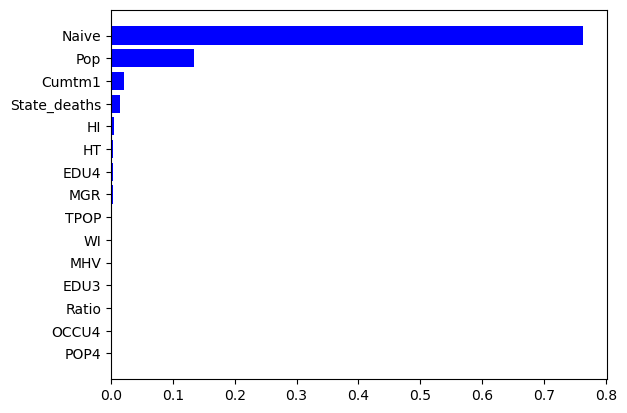

In [21]:
import matplotlib.pyplot as plt
import numpy as np

feats = X_train.columns.values
importances = reg.feature_importances_

indices = np.argsort(importances)[-15:]
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feats[i] for i in indices])
plt.show()

In [ ]:
# # # # # # # # # # #
# how_many = 28
# # # # # # # # # # #

# coef = abs(reg.coef_)
# ind = np.argpartition(coef, -how_many)[-how_many:]
# top = coef[ind]

# df_coefs = X_train.iloc[:, ind]
# which_feats = df_coefs.columns

# res_df = pd.DataFrame([top, which_feats], index=['coef','feat_name'])
# res_df = res_df.T.sort_values(by='coef',inplace=False,ascending=False)
# res_df = res_df[:how_many]

# import seaborn as sns
# import matplotlib.pyplot as plt


# DPI = 300

# plt.figure(figsize=(10,5))
# sns.barplot(res_df, y="coef", x="feat_name", legend=False)
# plt.title(f'{alg} coefs')
# # plt.xticks(xticks, rotation=45)
# plt.xticks(rotation=45,ha='right',wrap='True')

# sns.despine()
# plt.gcf().set_dpi(DPI)
# plt.show()